## Autoencoder for Song Orders:

In [1]:
from Autoencoder_alla_Valerio import Autoencoder
from Variational_Autoencoder_alla_Valerio import VAE
from LSTM_Autoencoder import LSTM_Autoencoder
import numpy as np
import matplotlib.pyplot as plt
from Snippets import Snippets
from IPython.display import display, Audio
import librosa
from tensorflow.keras.layers import Masking
import tensorflow as tf

### Input Data:
We load the array with all song_orders. We need to bring them all to the same size, so we can use them as training data

In [2]:
subfolder = "0.25_16"
model_name = "Valerio_23927"
song_orders = np.load("data_and_models\\" + subfolder + "\\" + model_name +"song_orders.npy", allow_pickle=True)

We can normalise the data and denormalise it later

In [3]:
flattened_orders = np.asarray([item for order in song_orders for item in order])
old_min = flattened_orders.min()
old_max = flattened_orders.max()

In [4]:
norm_orders = Snippets._normalise(song_orders, 0.01, 1, old_min, old_max)

For the training of the autoencoder, we need all song-orders to be of the same length. Additionally the length has to be an even number. We bring each song to the length of the longest song by adding the value -1. 

In [5]:
# max_song_length = 0

# for i in range(0, len(song_orders)):
#     if len(song_orders[i]) > max_song_length:
#         max_song_length = len(song_orders[i])
#         if not (max_song_length % 2) == 0: #increase max_song_length to even number. This is crutial for the Shape of Autoencoder input data.
#             max_song_length += 1       
# print("The longest song had: " + str(max_song_length) +"snippets")


# x_train = []
# for order in norm_orders:
#     if order.shape[0] < max_song_length:
#         padded_order = np.pad(order,((0,max_song_length-order.shape[0]),(0,0)), constant_values=(0,0))
#         x_train.append(padded_order)
# x_train = np.asarray(x_train)
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], 1)

# print("Our trainingsdata has the shape: " + str(x_train.shape))

In [6]:
# old_min = x_train.min()
# old_max = x_train.max()

# def normalise(array, new_min, new_max, old_min, old_max):
#         norm_array = (array - old_min) / (old_max - old_min)
#         norm_array = norm_array * (new_max - new_min) + new_min
#         return norm_array

# x_train = normalise(x_train, 0, 1, old_min, old_max)

In [7]:
# Add a channel for Mask 
#for order in norm_orders:
#     sample = []
#     for coordinates in order:
#         mask = np.sign(coordinates[0])
#         coordinates = np.append(coordinates, mask)
#         sample.append(coordinates)
#     sample = np.asarray(sample)
#     x_train.append(sample)
#x_train = np.asarray(x_train)


In [8]:
x_train = norm_orders
x_train[0].shape

(2119, 128)

In [13]:
x_train = []
for order in norm_orders:
    order = order.reshape(order.shape[0], order.shape[1], 1)
    x_train.append(order)
x_train = np.asarray(x_train)

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Build the model
We can build a new model

In [14]:
autoencoder = LSTM_Autoencoder(
    input_shape = (x_train[0].shape[1], x_train[0].shape[2]), 
    lstm_dims = (), 
    latent_space_dim = 32
)

# autoencoder = Autoencoder(
#     input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]),
#     conv_filters=(512, 256, 128, 64, 32),
#     conv_kernels=(3, 3, 3, 3, 3),
#     conv_strides=(2, 2, 2, 2, (2,1)),
#     latent_space_dim=32,
#     mask_value=0
# )
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 1)]          0         
_________________________________________________________________
encoder (Functional)         (None, None, 32)          4352      
_________________________________________________________________
decoder (Functional)         (None, None, 1)           8353      
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 1)]     0                                            
___________________________________________________________________

(2060, 128, 1)

In [26]:
LEARNING_RATE =  0.0001
EPOCHS = 100

autoencoder.compile_model(LEARNING_RATE)

for i in range(EPOCHS):
    np.random.shuffle(x_train);
    for j, sample in enumerate(x_train):
        autoencoder.model.train_on_batch(sample,sample)
        print("Epoch: " + str(i+1) + " Sample " + str(j+1), end="\r")

autoencoder.save("Autoencoder_SongOrders" + str(autoencoder.latent_space_dim) + "D_" + subfolder)

In [ ]:
autoencoder.save("Autoencoder_SongOrders" + str(autoencoder.latent_space_dim) + "D_" + subfolder)
autoencoder.summary()

# Check Results
Check how good the autoencoder is in reconstructing a song order.

In [27]:
song_num = 0
latent_representation = autoencoder.encoder.predict(x_train[song_num])
reconstructed_data = autoencoder.decoder.predict(latent_representation)
reconstructed_data = Snippets._denormalise(reconstructed_data, 0, 1, old_min, old_max)

original = x_train[song_num]
original = Snippets._denormalise(original, 0.01, 1, old_min, old_max)

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1016, 128, 1)

This is the original


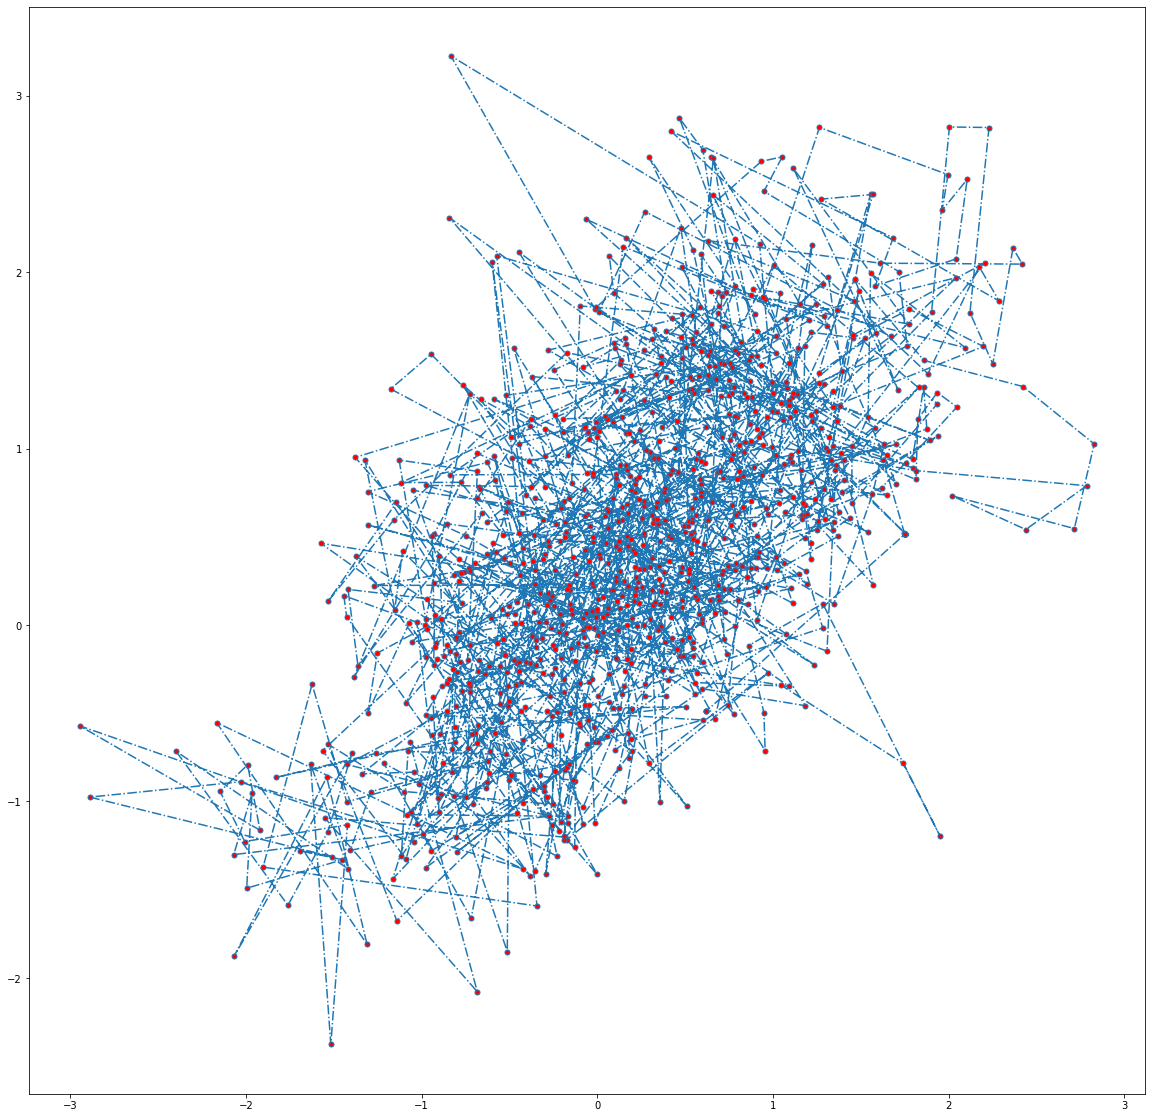

In [29]:
print("This is the original")
plt.figure(figsize=(20,20))
plt.plot(original[:, 0], original[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

This is the reconstruction


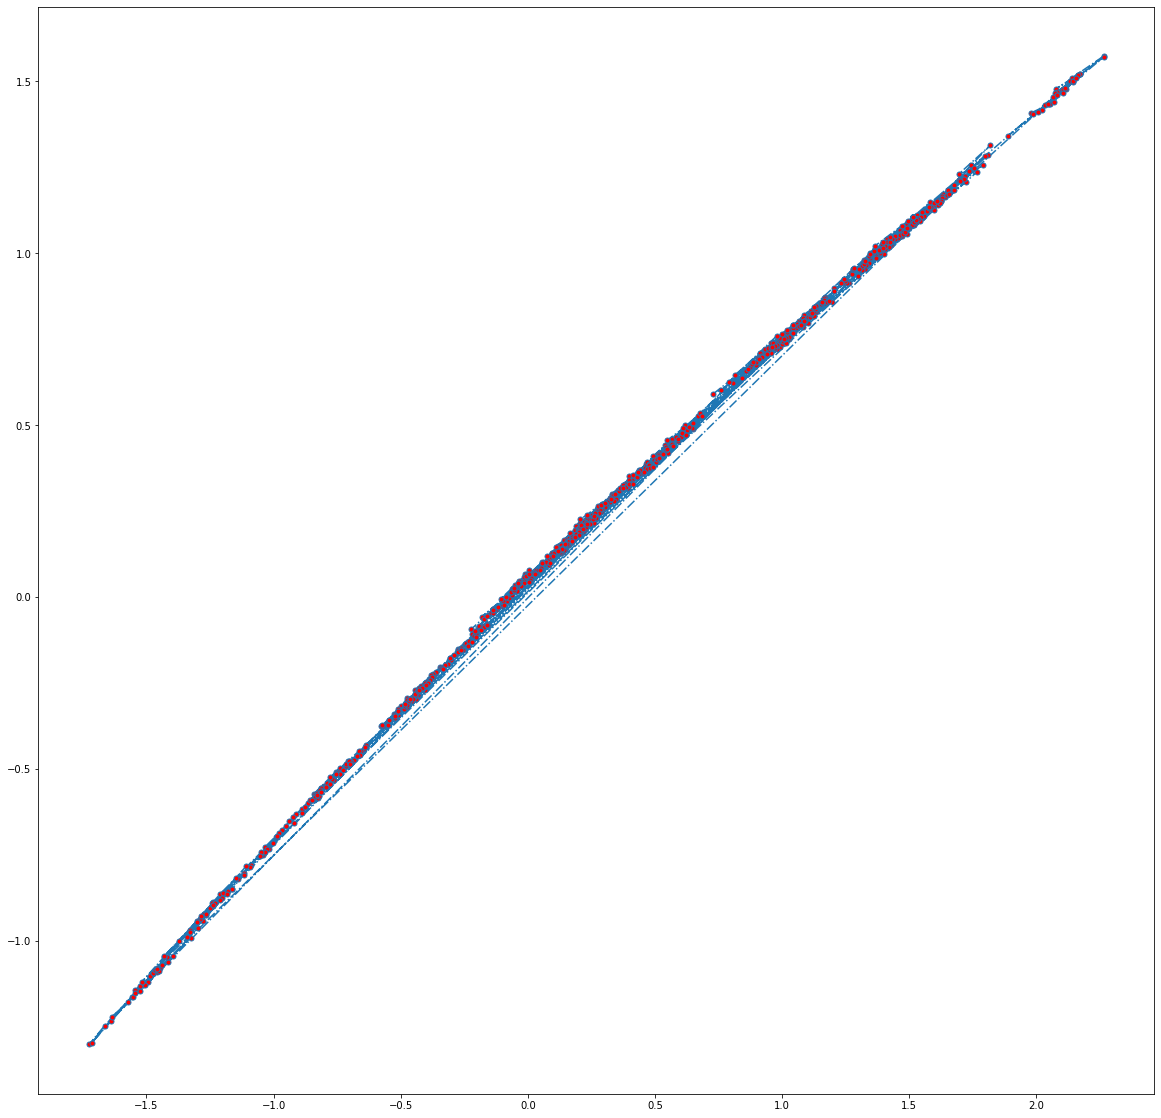

In [30]:
print("This is the reconstruction")
plt.figure(figsize=(20,20))
plt.plot(reconstructed_data[:, 0], reconstructed_data[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

In [ ]:
WIN_LENGTH = 690*2
HOP_LENGTH = 690
N_FFT = 690*2

snippet_model_name = "VAE_Vocals_128D_23927samples_20Epochs"
snippet_autoencoder = VAE.load("data_and_models\\" + subfolder +"\\" + snippet_model_name)

reconstructed_data = reconstructed_data.reshape(reconstructed_data.shape[0], reconstructed_data.shape[1])
print(reconstructed_data.shape)
      
reconstructed_signal, reconstructed_spectos = Snippets.latent_representation_to_pca(latent_representations=reconstructed_data,
                                                                                    model=snippet_autoencoder, 
                                                                                    hop_length=HOP_LENGTH, 
                                                                                    n_fft=N_FFT, 
                                                                                    win_length=WIN_LENGTH)

In [ ]:
display(Audio(reconstructed_signal, rate=44100))

In [ ]:
folder_path = 'demo_data\\stems'
paths = librosa.util.find_files(folder_path, ext=['wav'])
original_song, _ = librosa.load(paths[song_num],sr=44100, mono=True)

print("This is the original song: \n")
display(Audio(original_song, rate=44100))


https://machinelearningmastery.com/lstm-autoencoders/